#### Install additional libraries #####

In [3]:
%%capture
!pip install awswrangler
!pip install missingno
!pip install--upgrade plotly
!pip install --upgrade seaborn
!pip install mlxtend

In [4]:
import multiprocessing
import os

print(multiprocessing.cpu_count())

64


#### Import Libraries ####

In [5]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
from datetime import datetime, date, timedelta
import math
import warnings 
import pyodbc
import time
import pickle
import boto3
from io import BytesIO
import re
import awswrangler as wr
%matplotlib inline
import matplotlib.pyplot as plt
import missingno
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
from scipy.stats import skew
from scipy.stats import kurtosis

Matplotlib is building the font cache; this may take a moment.


In [6]:
warnings.filterwarnings("ignore")

In [7]:
# import multiprocessing
# import os

# print(multiprocessing.cpu_count())
# # print(os.cpu_count())

#### Read mortgage dataset

In [8]:
import time
start_time = time.time()
from io import BytesIO


df = wr.s3.read_csv("s3://daan888/projectcr/data/semiprocessed/mortgage_risk_unique_semi_processed.csv",skip_blank_lines=True)

df.reset_index(drop=True, inplace=True)

### clean columns names

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

print("--- %s seconds ---" % (time.time() - start_time))  

--- 0.7386224269866943 seconds ---


In [9]:
df.columns

Index(['id', 'time', 'orig_time', 'first_time', 'mat_time', 'balance_time',
       'ltv_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time',
       'retype_co_orig_time', 'retype_pu_orig_time', 'retype_sf_orig_time',
       'investor_orig_time', 'balance_orig_time', 'fico_orig_time',
       'ltv_orig_time', 'interest_rate_orig_time', 'hpi_orig_time',
       'default_time'],
      dtype='object')

In [10]:
# Initial Data Set Mortgage Description
# The data set mortgage is in panel form and reports origination and performance observations for 50,000 residential U.S. mortgage borrowers over 60 periods. The periods have been deidentified. As in the real world, loans may originate before the start of the observation period (this is an issue where loans are transferred between banks and investors as in securitization). The loan observations may thus be censored as the loans mature or borrowers refinance. The data set is a randomized selection of mortgage-loan-level data collected from the portfolios underlying U.S. residential mortgage-backed securities (RMBS) securitization portfolios and provided by International Financial Research (www.internationalfinancialresearch.org). Go to www.win-rar.com if ﻿you require a program to decompress. Key variables include:
# ◾ id: Borrower ID
# ◾ time: Time stamp of observation
# ◾ orig_time: Time stamp for origination
# ◾ first_time: Time stamp for first observation
# ◾ mat_time: Time stamp for maturity
# ◾ balance_time: Outstanding balance at observation time
# ◾ LTV_time: Loan-to-value ratio at observation time, in %
# ◾ interest_rate_time: Interest rate at observation time, in %
# ◾ hpi_time: House price index at observation time, base year = 100
# ◾ gdp_time: Gross domestic product (GDP) growth at observation time, in %
# ◾ uer_time: Unemployment rate at observation time, in %
# ◾ REtype_CO_orig_time: Real estate type condominium = 1, otherwise = 0
# ◾ REtype_PU_orig_time: Real estate type planned urban development = 1, otherwise = 0
# ◾ REtype_SF_orig_time: Single-family home = 1, otherwise = 0
# ◾ investor_orig_time: Investor borrower = 1, otherwise = 0
# ◾ balance_orig_time: Outstanding balance at origination time
# ◾ FICO_orig_time: FICO score at origination time, in %
# ◾ LTV_orig_time: Loan-to-value ratio at origination time, in %
# ◾ Interest_Rate_orig_time: Interest rate at origination time, in %
# ◾ hpi_orig_time: House price index at origination time, base year = 100
# ◾ default_time: Default observation at observation time

##### variable elimination

In [11]:
df.shape

(50000, 21)

In [12]:
len(df.columns)

21

In [13]:
# Rows containing duplicate data
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate records: ", duplicate_rows_df.shape[0])

number of duplicate records:  0


In [14]:
df.dtypes

id                           int64
time                         int64
orig_time                    int64
first_time                   int64
mat_time                     int64
balance_time               float64
ltv_time                   float64
interest_rate_time         float64
hpi_time                   float64
gdp_time                   float64
uer_time                   float64
retype_co_orig_time          int64
retype_pu_orig_time          int64
retype_sf_orig_time          int64
investor_orig_time           int64
balance_orig_time          float64
fico_orig_time               int64
ltv_orig_time              float64
interest_rate_orig_time    float64
hpi_orig_time              float64
default_time                 int64
dtype: object

In [15]:
import pandas as pd
from pandas import option_context

with option_context("display.max_rows", None,"display.max_colwidth",60,"display.max_columns",50):
        display(df.head(2))

,id,time,orig_time,first_time,mat_time,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,balance_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time,hpi_orig_time,default_time
0,1,48,-7,25,113,29087.21,26.658065,9.20,146.45,2.715903,8.3,0,0,1,0,45000.0,715,69.4,9.20,87.03,1
1,2,26,18,25,138,105654.77,65.469851,7.68,225.10,2.151365,4.7,0,0,1,0,107200.0,558,80.0,7.68,186.91,0


###### we will be dropping the followiing variables from our dataset:
######  'id', 'time', 'orig_time',  'mat_time','first_time','balance_orig_time','balance_orig_time','hpi_orig_time'
###### based on the results from section  #6

In [16]:
df.drop(['id', 'time', 'orig_time',  'mat_time','first_time','balance_orig_time',
        'hpi_orig_time'], axis=1, inplace=True)

In [17]:
df.columns

Index(['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time',
       'retype_sf_orig_time', 'investor_orig_time', 'fico_orig_time',
       'ltv_orig_time', 'interest_rate_orig_time', 'default_time'],
      dtype='object')

In [18]:
21 - len(df.columns)

7

In [19]:
df.shape

(50000, 14)

In [20]:
import pandas as pd
from pandas import option_context

with option_context("display.max_rows", None,"display.max_colwidth",60,"display.max_columns",50):
        display(df.head(2))

,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time,default_time
0,29087.21,26.658065,9.20,146.45,2.715903,8.3,0,0,1,0,715,69.4,9.20,1
1,105654.77,65.469851,7.68,225.10,2.151365,4.7,0,0,1,0,558,80.0,7.68,0


In [21]:

# df['default_time'] = df['default_time'].astype('category')

In [22]:
######### Convert some int var to object based on description ########

In [23]:
print(df.default_time.unique())


print('------------')


[1 0]
------------


In [24]:
print(df.retype_co_orig_time.unique())


print('------------')
print('------------')


print(df.retype_pu_orig_time.unique())

[0 1]
------------
------------
[0 1]


In [25]:
print(df.retype_sf_orig_time.unique())


print('------------')
print('------------')


print(df.investor_orig_time.unique())

[1 0]
------------
------------
[0 1]


In [26]:
import time
start_time = time.time()

df['retype_co_orig_time'] = df['retype_co_orig_time'].astype(object)

df['retype_pu_orig_time'] = df['retype_pu_orig_time'].astype(object)

df['retype_sf_orig_time'] = df['retype_sf_orig_time'].astype(object)

df['investor_orig_time'] = df['investor_orig_time'].astype(object)

print("--- %s seconds ---" % (time.time() - start_time))  

--- 0.006349325180053711 seconds ---


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   balance_time             50000 non-null  float64
 1   ltv_time                 49982 non-null  float64
 2   interest_rate_time       50000 non-null  float64
 3   hpi_time                 50000 non-null  float64
 4   gdp_time                 50000 non-null  float64
 5   uer_time                 50000 non-null  float64
 6   retype_co_orig_time      50000 non-null  object 
 7   retype_pu_orig_time      50000 non-null  object 
 8   retype_sf_orig_time      50000 non-null  object 
 9   investor_orig_time       50000 non-null  object 
 10  fico_orig_time           50000 non-null  int64  
 11  ltv_orig_time            50000 non-null  float64
 12  interest_rate_orig_time  50000 non-null  float64
 13  default_time             50000 non-null  int64  
dtypes: float64(8), int64(2

In [28]:
df.describe()

,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time,default_time
count,5.000000e+04,49982.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.389723e+05,79.312091,7.014623,190.291879,1.690324,6.000876,661.297200,79.707362,5.442125,0.303080
std,2.030908e+05,25.132774,2.214244,26.286099,1.917736,1.674600,72.795473,9.920389,3.288040,0.459594
min,0.000000e+00,0.000000,0.000000,107.830000,-4.146711,3.800000,400.000000,50.100000,0.000000,0.000000
25%,1.058409e+05,64.116470,5.875000,162.090000,1.229172,4.700000,611.000000,75.000000,3.000000,0.000000
50%,1.835795e+05,78.718905,7.000000,189.820000,2.274218,5.500000,663.000000,80.000000,6.375000,0.000000
75%,3.195667e+05,95.745375,8.350000,217.370000,2.836358,6.500000,715.000000,85.000000,7.625000,1.000000
max,8.688101e+06,616.985143,37.500000,226.290000,5.132464,10.000000,840.000000,218.500000,19.750000,1.000000


In [29]:
######## missing values exp########

In [30]:
print(df.isna().sum().sum())

18


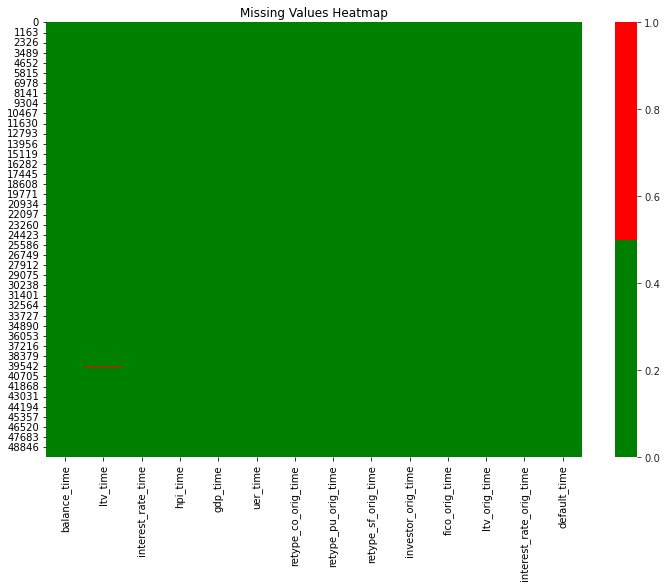

In [31]:
cols = df.columns 
colours = ['g', 'r'] 
f, ax = plt.subplots(figsize = (12,8))
sns.set_style("whitegrid")
plt.title('Missing Values Heatmap', )
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours));

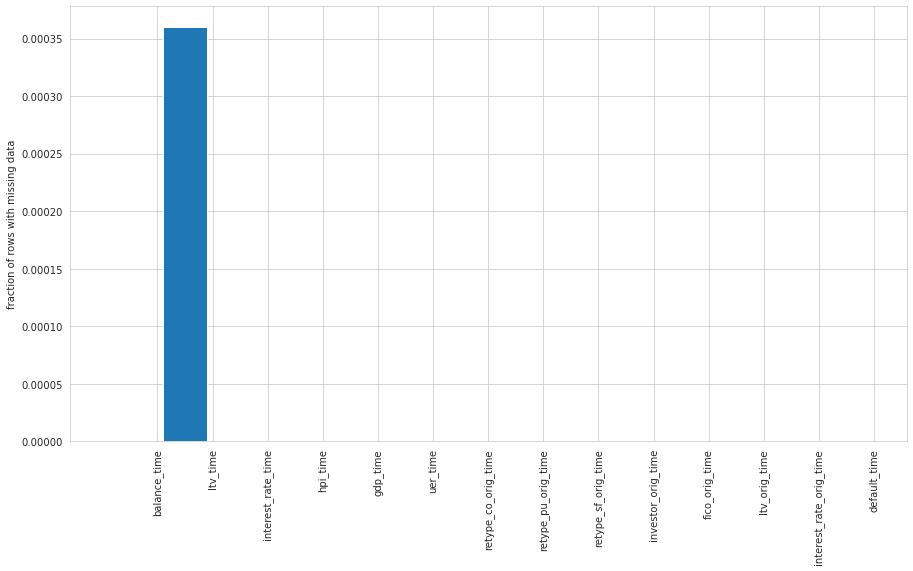

In [32]:
null_counts = df.isnull().sum()/len(df)
plt.figure(figsize=(15,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)
plt.show()

In [33]:
df.isna().sum()

balance_time                0
ltv_time                   18
interest_rate_time          0
hpi_time                    0
gdp_time                    0
uer_time                    0
retype_co_orig_time         0
retype_pu_orig_time         0
retype_sf_orig_time         0
investor_orig_time          0
fico_orig_time              0
ltv_orig_time               0
interest_rate_orig_time     0
default_time                0
dtype: int64

In [34]:
missing_count = df.isnull().sum() # the count of missing values
value_count = df.isnull().count() # the count of all values 
missing_percentage = round(missing_count / value_count * 100,2) #the percentage of missing values
missing_df = pd.DataFrame({'count': missing_count, 'percentage': missing_percentage}) #create a dataframe
print(missing_df)

                         count  percentage
balance_time                 0        0.00
ltv_time                    18        0.04
interest_rate_time           0        0.00
hpi_time                     0        0.00
gdp_time                     0        0.00
uer_time                     0        0.00
retype_co_orig_time          0        0.00
retype_pu_orig_time          0        0.00
retype_sf_orig_time          0        0.00
investor_orig_time           0        0.00
fico_orig_time               0        0.00
ltv_orig_time                0        0.00
interest_rate_orig_time      0        0.00
default_time                 0        0.00


###### Fill missing values 

In [35]:
from statsmodels.graphics.gofplots import qqplot

In [36]:
import pandas as pd
from pandas import option_context

with option_context("display.max_rows", None,"display.max_colwidth",60,"display.max_columns",50):
        display(df['ltv_time'].describe().reset_index().transpose().rename({'index':'statistics'}))

,0,1,2,3,4,5,6,7
statistics,count,mean,std,min,25%,50%,75%,max
ltv_time,49982,79.3121,25.1328,0,64.1165,78.7189,95.7454,616.985


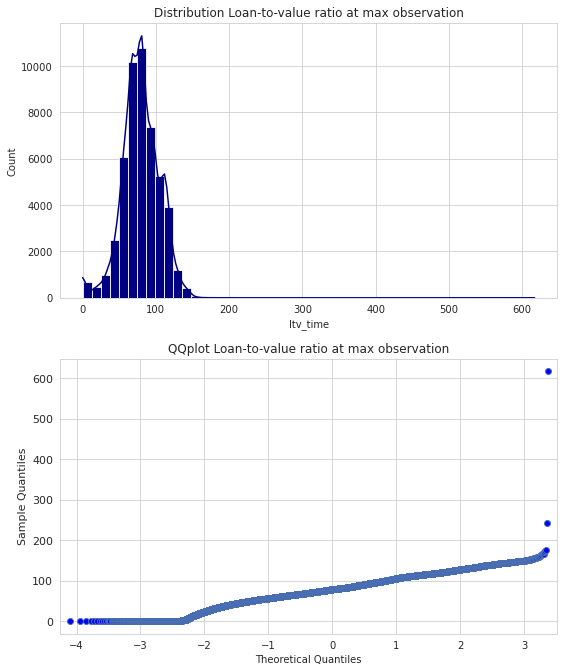

In [37]:
from scipy.stats import skew
from scipy.stats import kurtosis


fig, axs = plt.subplots(2, figsize=(8, 9.5))

sns.set(style="whitegrid")
#plt.figure(figsize=(11,8))

sns.histplot(data = df
            ,x = 'ltv_time'
            ,color = 'navy'
            ,alpha = 1
             ,bins = 50
             ,kde = True,ax=axs[0]
            )

# plt.xticks(size=11)
# axs[0].xlabel('Loan borrower fico score', size=  11)
plt.yticks(size=11)
plt.ylabel('Count', size=  11)
axs[0].set_title("Distribution Loan-to-value ratio at max observation")

qqplot(df['ltv_time'],line='s',ax=axs[1])
axs[1].set_title("QQplot Loan-to-value ratio at max observation")

target= 'ltv_time'

# print('-*-'*14)
# # print("{0} mean : ".format(target), np.mean(df[target]))
# print("{0} var  : ".format(target), np.var(df[target]))
# print("{0} skew : ".format(target), skew(df[target]))
# print("{0} kurt : ".format(target), kurtosis(df[target]))
# # print('-*-'*15)

plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
from pandas import option_context

with option_context("display.max_rows", None,"display.max_colwidth",60,"display.max_columns",50):
        display(df['ltv_time'].describe().reset_index().transpose().rename({'index':'statistics'}))

,0,1,2,3,4,5,6,7
statistics,count,mean,std,min,25%,50%,75%,max
ltv_time,49982,79.3121,25.1328,0,64.1165,78.7189,95.7454,616.985


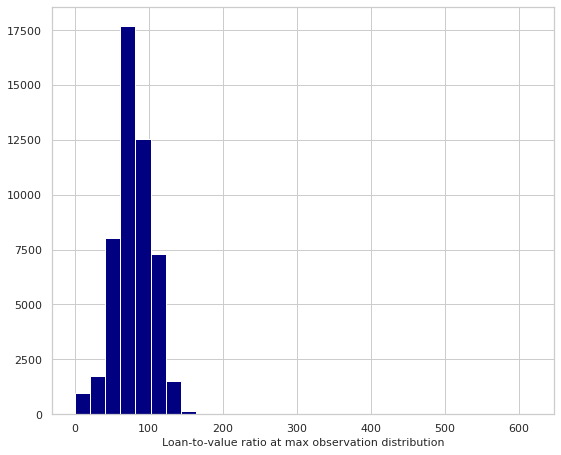

In [39]:
plt.figure( figsize =(9, 7.5))

# bins = np.arange(df['ltv_time'].min(), df['ltv_time'].max())

plt.hist(df['ltv_time'],bins = 30,color = 'navy')

plt.xlabel('Loan-to-value ratio at max observation distribution', size=  11)

plt.show()

##### Fill with median based on the distribution

In [40]:
import time
start_time = time.time()


df['ltv_time'].fillna(df['ltv_time'].median(), inplace = True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0010826587677001953 seconds ---


In [41]:
##### Check 

In [42]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [43]:
missing_values_table(df)

Your selected dataframe has 14 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [44]:
missing_count = df.isnull().sum() # the count of missing values
value_count = df.isnull().count() # the count of all values 
missing_percentage = round(missing_count / value_count * 100,2) #the percentage of missing values
missing_df = pd.DataFrame({'count': missing_count, 'percentage': missing_percentage}) #create a dataframe
print(missing_df)

                         count  percentage
balance_time                 0         0.0
ltv_time                     0         0.0
interest_rate_time           0         0.0
hpi_time                     0         0.0
gdp_time                     0         0.0
uer_time                     0         0.0
retype_co_orig_time          0         0.0
retype_pu_orig_time          0         0.0
retype_sf_orig_time          0         0.0
investor_orig_time           0         0.0
fico_orig_time               0         0.0
ltv_orig_time                0         0.0
interest_rate_orig_time      0         0.0
default_time                 0         0.0


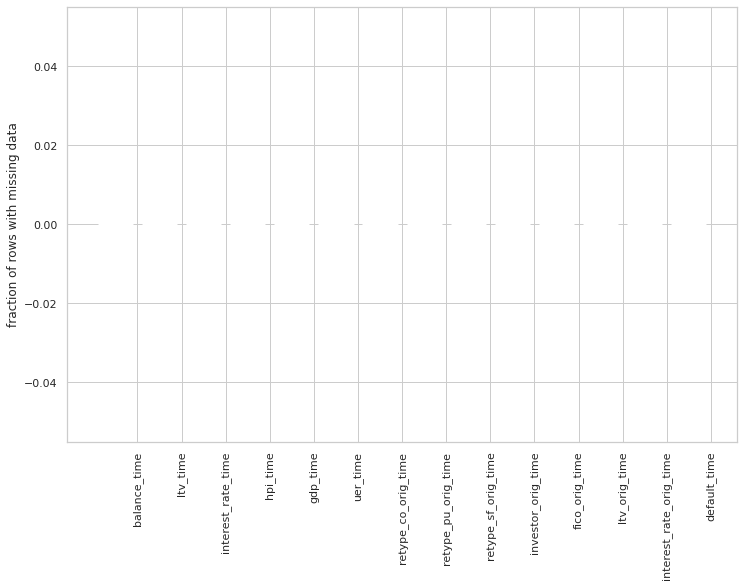

In [45]:
null_counts = df.isnull().sum()/len(df)
plt.figure(figsize=(12,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)
plt.show()

In [46]:
import pandas as pd
from pandas import option_context

with option_context("display.max_rows", None,"display.max_colwidth",60,"display.max_columns",50):
        display(df.head(2))

,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time,default_time
0,29087.21,26.658065,9.20,146.45,2.715903,8.3,0,0,1,0,715,69.4,9.20,1
1,105654.77,65.469851,7.68,225.10,2.151365,4.7,0,0,1,0,558,80.0,7.68,0


In [47]:
import pandas as pd
from pandas import option_context

with option_context("display.max_rows", None,"display.max_colwidth",60,"display.max_columns",50):
        display(df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
balance_time,50000.0,238972.292454,203090.780403,0.000000,105840.930000,183579.535000,319566.747500,8.688101e+06
ltv_time,50000.0,79.311878,25.128253,0.000000,64.117145,78.718905,95.736850,6.169851e+02
interest_rate_time,50000.0,7.014623,2.214244,0.000000,5.875000,7.000000,8.350000,3.750000e+01
hpi_time,50000.0,190.291879,26.286099,107.830000,162.090000,189.820000,217.370000,2.262900e+02
gdp_time,50000.0,1.690324,1.917736,-4.146711,1.229172,2.274218,2.836358,5.132464e+00
uer_time,50000.0,6.000876,1.674600,3.800000,4.700000,5.500000,6.500000,1.000000e+01
fico_orig_time,50000.0,661.297200,72.795473,400.000000,611.000000,663.000000,715.000000,8.400000e+02
ltv_orig_time,50000.0,79.707362,9.920389,50.100000,75.000000,80.000000,85.000000,2.185000e+02
interest_rate_orig_time,50000.0,5.442125,3.288040,0.000000,3.000000,6.375000,7.625000,1.975000e+01
default_time,50000.0,0.303080,0.459594,0.000000,0.000000,0.000000,1.000000,1.000000e+00


In [48]:
import pandas as pd
from pandas import option_context

with option_context("display.max_rows", None,"display.max_colwidth",60,"display.max_columns",50):
        display(df.head(2))

,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time,default_time
0,29087.21,26.658065,9.20,146.45,2.715903,8.3,0,0,1,0,715,69.4,9.20,1
1,105654.77,65.469851,7.68,225.10,2.151365,4.7,0,0,1,0,558,80.0,7.68,0


In [49]:
###### ltv_orig_time

In [50]:
import pandas as pd
from pandas import option_context

with option_context("display.max_rows", None,"display.max_colwidth",60,"display.max_columns",50):
        display(df['ltv_orig_time'].describe().reset_index().transpose().rename({'index':'statistics'}))

,0,1,2,3,4,5,6,7
statistics,count,mean,std,min,25%,50%,75%,max
ltv_orig_time,50000,79.7074,9.92039,50.1,75,80,85,218.5


-*--*--*--*--*--*--*--*--*--*--*--*--*--*-
ltv_orig_time var  :  98.4121468009633
ltv_orig_time skew :  -0.19371971632463808
ltv_orig_time kurt :  1.7099654631344636


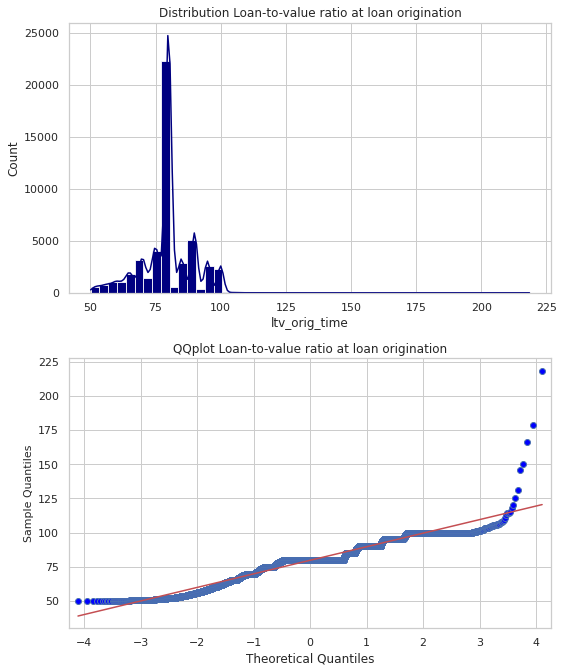

In [51]:
from scipy.stats import skew
from scipy.stats import kurtosis


fig, axs = plt.subplots(2, figsize=(8, 9.5))

sns.set(style="whitegrid")
#plt.figure(figsize=(11,8))

sns.histplot(data = df
            ,x = 'ltv_orig_time'
            ,color = 'navy'
            ,alpha = 1
             ,bins = 50
             ,kde = True,ax=axs[0]
            )

# plt.xticks(size=11)
# axs[0].xlabel('Loan borrower fico score', size=  11)
plt.yticks(size=11)
plt.ylabel('Count', size=  11)
axs[0].set_title("Distribution Loan-to-value ratio at loan origination")

qqplot(df['ltv_orig_time'],line='s',ax=axs[1])
axs[1].set_title("QQplot Loan-to-value ratio at loan origination")

target= 'ltv_orig_time'

print('-*-'*14)
# print("{0} mean : ".format(target), np.mean(df[target]))
print("{0} var  : ".format(target), np.var(df[target]))
print("{0} skew : ".format(target), skew(df[target]))
print("{0} kurt : ".format(target), kurtosis(df[target]))
# print('-*-'*15)

plt.tight_layout()
plt.show()

In [52]:
##### balance_time

In [53]:
import pandas as pd
from pandas import option_context

with option_context("display.max_rows", None,"display.max_colwidth",60,"display.max_columns",50):
        display(df['balance_time'].describe().reset_index().transpose().rename({'index':'statistics'}))

,0,1,2,3,4,5,6,7
statistics,count,mean,std,min,25%,50%,75%,max
balance_time,50000,238972,203091,0,105841,183580,319567,8.6881e+06


-*--*--*--*--*--*--*--*--*--*--*--*--*--*-
balance_time var  :  41245040167.52955
balance_time skew :  4.554891782429521
balance_time kurt :  97.42686955244514


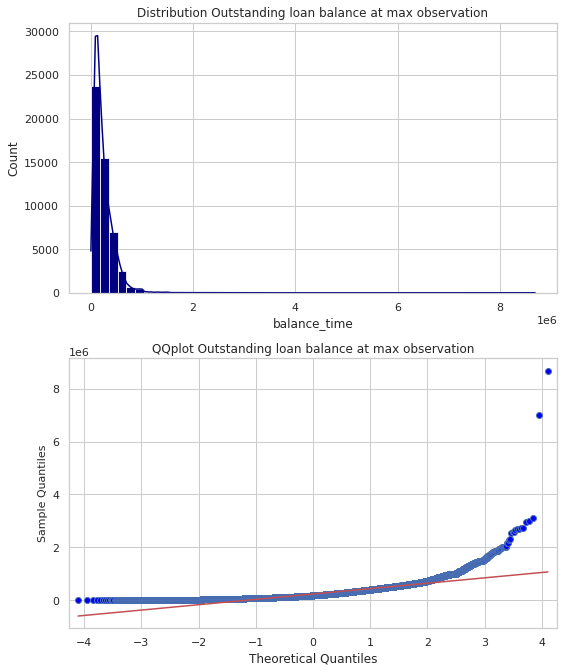

In [54]:
from scipy.stats import skew
from scipy.stats import kurtosis


fig, axs = plt.subplots(2, figsize=(8, 9.5))

sns.set(style="whitegrid")
#plt.figure(figsize=(11,8))

sns.histplot(data = df
            ,x = 'balance_time'
            ,color = 'navy'
            ,alpha = 1
             ,bins = 50
             ,kde = True,ax=axs[0]
            )

# plt.xticks(size=11)
# axs[0].xlabel('Loan borrower fico score', size=  11)
plt.yticks(size=11)
plt.ylabel('Count', size=  11)
axs[0].set_title("Distribution Outstanding loan balance at max observation")

qqplot(df['balance_time'],line='s',ax=axs[1])
axs[1].set_title("QQplot Outstanding loan balance at max observation")

target= 'balance_time'

print('-*-'*14)
# print("{0} mean : ".format(target), np.mean(df[target]))
print("{0} var  : ".format(target), np.var(df[target]))
print("{0} skew : ".format(target), skew(df[target]))
print("{0} kurt : ".format(target), kurtosis(df[target]))
# print('-*-'*15)

plt.tight_layout()
plt.show()

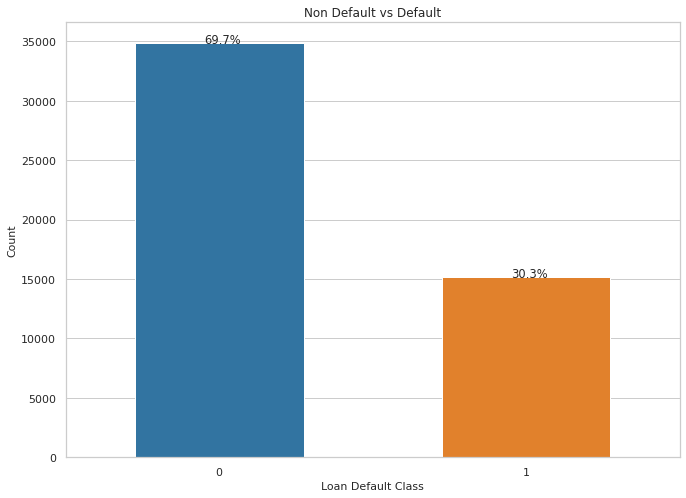

In [55]:
##### class proportion before this outliers removal


sns.set(style="whitegrid")
plt.figure(figsize=(11,8))

color_labels = df['default_time'].unique()

# List of color palette to use
rgb_values = sns.color_palette("tab10", 2)

# Map label to color palette

color_map = dict(zip(color_labels, rgb_values))


ax = sns.countplot(x="default_time", data=df,palette=df['default_time'].map(color_map))

plt.xticks(size=11)
plt.xlabel('Loan Default Class', size=  11)
plt.yticks(size=11)
plt.ylabel('Count', size=  11)

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 11.5)
    
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .55)

without_hue(ax, df.default_time)
plt.title('Non Default vs Default')
plt.show()

In [56]:
########## Normalized these two observations  using IQR Method trimming at both ends to remove outliers#########

In [57]:
df.shape

(50000, 14)

In [58]:
df.columns

Index(['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time',
       'retype_sf_orig_time', 'investor_orig_time', 'fico_orig_time',
       'ltv_orig_time', 'interest_rate_orig_time', 'default_time'],
      dtype='object')

In [59]:
import time

start_time = time.time()


df['ltv_orig_time'] = df['ltv_orig_time'][df['ltv_orig_time'].between(df['ltv_orig_time'].quantile(.01), df['ltv_orig_time'].quantile(.95), inclusive=True)]


df['balance_time'] = df['balance_time'][df['balance_time'].between(df['balance_time'].quantile(.02), df['balance_time'].quantile(.95), inclusive=True)]

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.016022682189941406 seconds ---


In [60]:
df[(df['balance_time'].notna()) & (df['ltv_orig_time'].notna())].shape

(43685, 14)

In [61]:
df = df[(df['balance_time'].notna()) & (df['ltv_orig_time'].notna())]
df.reset_index(drop=True, inplace=True)

In [62]:

from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 100,'display.max_columns',50):
              display(df.isnull().sum())

balance_time               0
ltv_time                   0
interest_rate_time         0
hpi_time                   0
gdp_time                   0
uer_time                   0
retype_co_orig_time        0
retype_pu_orig_time        0
retype_sf_orig_time        0
investor_orig_time         0
fico_orig_time             0
ltv_orig_time              0
interest_rate_orig_time    0
default_time               0
dtype: int64

In [63]:
######### reviewed Proportion of our target variable #################

In [64]:
df['default_time'].value_counts()

0    30087
1    13598
Name: default_time, dtype: int64

In [65]:
df['default_time'].value_counts(normalize=True)

0    0.688726
1    0.311274
Name: default_time, dtype: float64

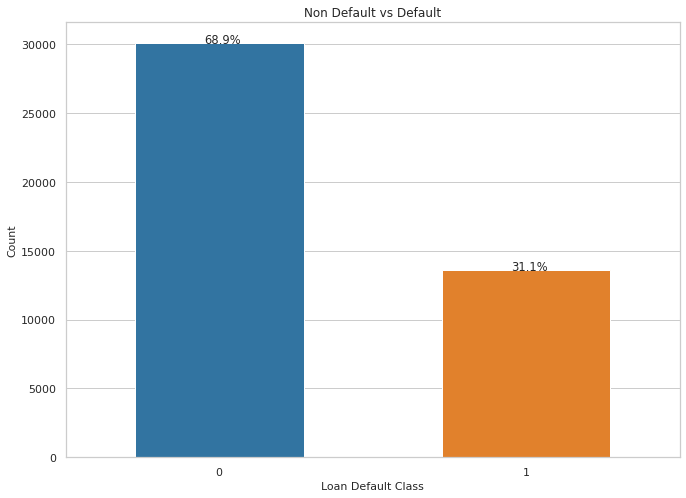

In [66]:
sns.set(style="whitegrid")
plt.figure(figsize=(11,8))

color_labels = df['default_time'].unique()

# List of color palette to use
rgb_values = sns.color_palette("tab10", 2)

# Map label to color palette

color_map = dict(zip(color_labels, rgb_values))


ax = sns.countplot(x="default_time", data=df,palette=df['default_time'].map(color_map))

plt.xticks(size=11)
plt.xlabel('Loan Default Class', size=  11)
plt.yticks(size=11)
plt.ylabel('Count', size=  11)

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 11.5)
    
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .55)

without_hue(ax, df.default_time)
plt.title('Non Default vs Default')
plt.show()

In [67]:
###### % percent change of dataset size

In [68]:
 def get_change(current, previous):
    if current == previous:
        return 0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return float('inf')

In [69]:
get_change(43685, 50000)

12.629999999999999

In [70]:
((float(43685)-50000)/50000)*100

-12.629999999999999

In [71]:
50000 - 43685

6315

In [72]:
##### We lose 6315 observations

In [73]:
############ Plot measures of spread distr for these two variables ###########

-*--*--*--*--*--*--*--*--*--*--*--*--*--*-
balance_time var  :  18283766598.42546
balance_time skew :  0.8097192637554002
balance_time kurt :  -0.2140133025746791


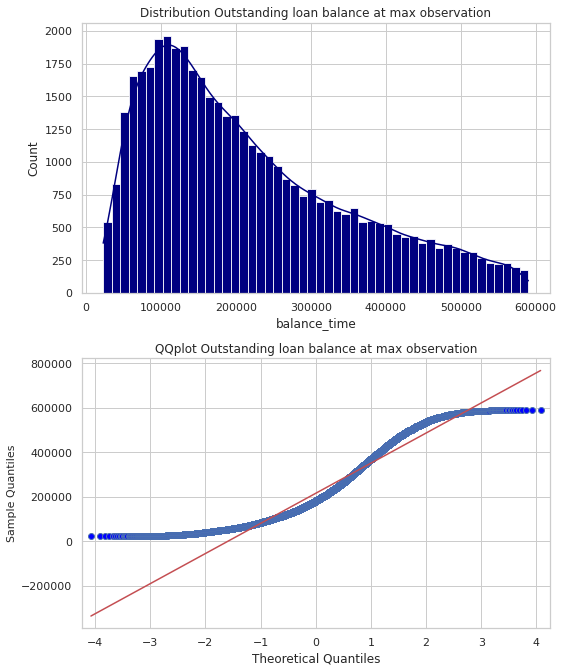

In [74]:
from scipy.stats import skew
from scipy.stats import kurtosis


fig, axs = plt.subplots(2, figsize=(8, 9.5))

sns.set(style="whitegrid")
#plt.figure(figsize=(11,8))

sns.histplot(data = df
            ,x = 'balance_time'
            ,color = 'navy'
            ,alpha = 1
             ,bins = 50
             ,kde = True,ax=axs[0]
            )

# plt.xticks(size=11)
# axs[0].xlabel('Loan borrower fico score', size=  11)
plt.yticks(size=11)
plt.ylabel('Count', size=  11)
axs[0].set_title("Distribution Outstanding loan balance at max observation")

qqplot(df['balance_time'],line='s',ax=axs[1])
axs[1].set_title("QQplot Outstanding loan balance at max observation")

target= 'balance_time'

print('-*-'*14)
# print("{0} mean : ".format(target), np.mean(df[target]))
print("{0} var  : ".format(target), np.var(df[target]))
print("{0} skew : ".format(target), skew(df[target]))
print("{0} kurt : ".format(target), kurtosis(df[target]))
# print('-*-'*15)

plt.tight_layout()
plt.show()

-*--*--*--*--*--*--*--*--*--*--*--*--*--*-
ltv_orig_time var  :  71.5587268353995
ltv_orig_time skew :  -0.5576682996569874
ltv_orig_time kurt :  0.6999946573020464


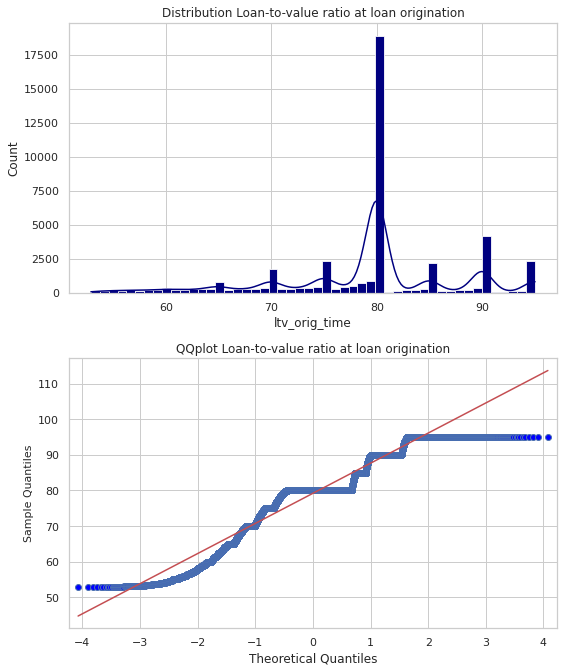

In [75]:
from scipy.stats import skew
from scipy.stats import kurtosis


fig, axs = plt.subplots(2, figsize=(8, 9.5))

sns.set(style="whitegrid")
#plt.figure(figsize=(11,8))

sns.histplot(data = df
            ,x = 'ltv_orig_time'
            ,color = 'navy'
            ,alpha = 1
             ,bins = 50
             ,kde = True,ax=axs[0]
            )

# plt.xticks(size=11)
# axs[0].xlabel('Loan borrower fico score', size=  11)
plt.yticks(size=11)
plt.ylabel('Count', size=  11)
axs[0].set_title("Distribution Loan-to-value ratio at loan origination")

qqplot(df['ltv_orig_time'],line='s',ax=axs[1])
axs[1].set_title("QQplot Loan-to-value ratio at loan origination")

target= 'ltv_orig_time'

print('-*-'*14)
# print("{0} mean : ".format(target), np.mean(df[target]))
print("{0} var  : ".format(target), np.var(df[target]))
print("{0} skew : ".format(target), skew(df[target]))
print("{0} kurt : ".format(target), kurtosis(df[target]))
# print('-*-'*15)

plt.tight_layout()
plt.show()

###### Variable selection methods

In [76]:
df.shape

(43685, 14)

In [77]:
df.columns

Index(['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time',
       'retype_sf_orig_time', 'investor_orig_time', 'fico_orig_time',
       'ltv_orig_time', 'interest_rate_orig_time', 'default_time'],
      dtype='object')

In [78]:
#### rename target

df.rename(columns={'default_time': 'default'}, inplace=True)

In [79]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [80]:
df= movecol(df, 
             cols_to_move=['default'], 
             ref_col='balance_time',
             place='Before')

df.reset_index(drop=True, inplace=True)

###### SelectKBest

In [81]:
#### Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

In [82]:
# Define categorical columns
categorical = list(df.select_dtypes(['category','O']).columns)
print(f"Categorical columns are: {categorical}")

# Define numerical columns
numerical = list(df.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['retype_co_orig_time', 'retype_pu_orig_time', 'retype_sf_orig_time', 'investor_orig_time']
Numerical columns are: ['default', 'balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'fico_orig_time', 'ltv_orig_time', 'interest_rate_orig_time']


In [83]:
# dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])

In [84]:
# Partition data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['default']), 
                                                    df['default'], 
                                                    test_size=.20, 
                                                    random_state=101,
                                                   stratify=df['default'])

# Define categorical columns
categorical = list(X_train.select_dtypes(['category','O']).columns)
print(f"Categorical columns are: {categorical}")

# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['retype_co_orig_time', 'retype_pu_orig_time', 'retype_sf_orig_time', 'investor_orig_time']
Numerical columns are: ['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'fico_orig_time', 'ltv_orig_time', 'interest_rate_orig_time']


In [85]:
X_train[numerical]

,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time
10273,185500.00,114.797993,8.500,151.48,-3.516568,7.8,651,80.0,8.500
10761,170216.90,61.446561,6.250,222.39,2.361722,4.4,722,63.7,6.250
18390,145116.32,41.777006,5.875,189.82,2.836358,5.7,683,89.8,5.875
30314,123970.75,118.023669,7.750,153.35,-4.146711,9.0,734,82.0,7.100
722,553500.00,112.225792,9.900,180.52,0.836859,5.0,609,90.0,0.000
...,...,...,...,...,...,...,...,...,...
23823,217756.38,114.157532,7.350,153.35,-4.146711,9.0,617,80.0,7.350
16813,148143.48,46.015577,5.750,161.00,3.029499,9.4,704,63.1,5.750
28862,538028.38,109.124449,6.875,162.09,-2.805844,6.5,761,80.0,6.875
43341,180145.47,92.324419,5.250,189.82,2.836358,5.7,611,80.0,5.250


In [86]:
###### Use mix max scaler in training x 

In [87]:
X_train[numerical].columns

Index(['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'fico_orig_time', 'ltv_orig_time',
       'interest_rate_orig_time'],
      dtype='object')

In [88]:
scaler = MinMaxScaler()

In [89]:
X_train[['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'fico_orig_time', 'ltv_orig_time',
       'interest_rate_orig_time']] = scaler.fit_transform(X_train[['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'fico_orig_time', 'ltv_orig_time',
       'interest_rate_orig_time']])

In [90]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',50,'display.max_columns',50):
        display(X_train.head(2))

,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time
10273,0.286878,0.178394,0.226667,0.368479,0.067909,0.645161,0,0,1,0,0.578341,0.643705,0.472222
10761,0.259949,0.091108,0.166667,0.967077,0.701402,0.096774,0,1,0,0,0.741935,0.256532,0.347222


In [91]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',50,'display.max_columns',50):
        display(X_train.head(2))

,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time
10273,0.286878,0.178394,0.226667,0.368479,0.067909,0.645161,0,0,1,0,0.578341,0.643705,0.472222
10761,0.259949,0.091108,0.166667,0.967077,0.701402,0.096774,0,1,0,0,0.741935,0.256532,0.347222


In [92]:
X_train[X_train.columns[6:8]]

,retype_co_orig_time,retype_pu_orig_time
10273,0,0
10761,0,1
18390,1,0
30314,0,0
722,0,0
...,...,...
23823,0,0
16813,0,0
28862,0,0
43341,1,0


In [93]:
##### Then run SelectKbest to select the 8 best features

In [94]:
import time

start_time = time.time()

X_8_best = SelectKBest(chi2, k=8).fit(X_train,y_train)


print("--- %s seconds ---" % (time.time() - start_time))

--- 0.030104637145996094 seconds ---


In [95]:
print('Score list:', X_8_best.scores_)
# print('Feature list:', X_train.columns)

Score list: [1.93898292e+01 9.43356632e+01 1.84472567e+01 3.18234289e+02
 3.78644364e+02 9.24066706e+02 4.31183847e-01 2.63463130e+00
 6.85110611e-02 1.70498673e+01 1.83334471e+01 2.11440611e+01
 4.08189138e+01]


In [96]:
chi_support = X_8_best.get_support()
chi_feature = X_train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

8 selected features


In [97]:
print('selected features : ',str(chi_feature)) 

selected features :  ['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'ltv_orig_time', 'interest_rate_orig_time']


In [98]:
X_train.loc[:,chi_support].columns.tolist()

['balance_time',
 'ltv_time',
 'interest_rate_time',
 'hpi_time',
 'gdp_time',
 'uer_time',
 'ltv_orig_time',
 'interest_rate_orig_time']

In [99]:
X_8_best.scores_[0:8]

array([1.93898292e+01, 9.43356632e+01, 1.84472567e+01, 3.18234289e+02,
       3.78644364e+02, 9.24066706e+02, 4.31183847e-01, 2.63463130e+00])

In [100]:
pd.Series(X_8_best.scores_[0:8], index=X_train.loc[:,chi_support].columns).sort_values(ascending=False)

uer_time                   924.066706
gdp_time                   378.644364
hpi_time                   318.234289
ltv_time                    94.335663
balance_time                19.389829
interest_rate_time          18.447257
interest_rate_orig_time      2.634631
ltv_orig_time                0.431184
dtype: float64

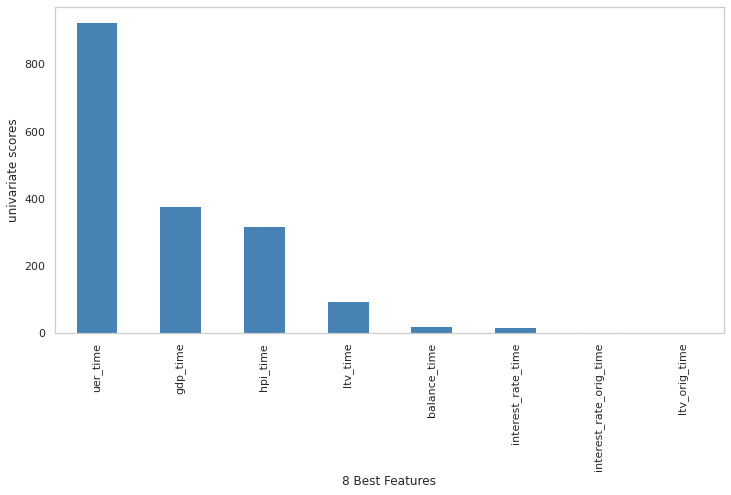

In [101]:
pd.Series(X_8_best.scores_[0:8], index=X_train.loc[:,chi_support].columns).sort_values(ascending=False).plot.bar(color='steelblue', figsize=(12, 6))
plt.grid(False)
plt.ylabel('univariate scores')
plt.xlabel('8 Best Features')

plt.show()

In [102]:
X_train.loc[:,chi_support].head(1)

,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,ltv_orig_time,interest_rate_orig_time
10273,0.286878,0.178394,0.226667,0.368479,0.067909,0.645161,0.643705,0.472222


In [103]:
print('selected features : ',str(chi_feature)) 

selected features :  ['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'ltv_orig_time', 'interest_rate_orig_time']


In [104]:
chi_feature

['balance_time',
 'ltv_time',
 'interest_rate_time',
 'hpi_time',
 'gdp_time',
 'uer_time',
 'ltv_orig_time',
 'interest_rate_orig_time']

###### Exhaustive Feature Selection

In [105]:
######Unlike the univariate method, RFE starts by fitting a model on the entire set 
######of features and computing an importance score for each predictor. 
###### The weakest features are then removed, the model is re-fitted, and importance scores
###### are computed again until the specified number of features are used. Features important
###### score are ranked by the model’s coef_ or feature_importances_ attributes, and 
###### by recursively eliminating a small number of features per loop.

In [106]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EXS

In [107]:
from sklearn.feature_selection import RFE

In [108]:
# Partition data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['default']), 
                                                    df['default'], 
                                                    test_size=.20, 
                                                    random_state=101,
                                                   stratify=df['default'])

# Define categorical columns
categorical = list(X_train.select_dtypes(['category','O']).columns)
print(f"Categorical columns are: {categorical}")

# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['retype_co_orig_time', 'retype_pu_orig_time', 'retype_sf_orig_time', 'investor_orig_time']
Numerical columns are: ['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'fico_orig_time', 'ltv_orig_time', 'interest_rate_orig_time']


In [109]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',50,'display.max_columns',50):
        display(X_train.head(2))

,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time
10273,185500.0,114.797993,8.50,151.48,-3.516568,7.8,0,0,1,0,651,80.0,8.50
10761,170216.9,61.446561,6.25,222.39,2.361722,4.4,0,1,0,0,722,63.7,6.25


In [110]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100)

In [111]:
import time

start_time = time.time()

efs = EFS(clf,
          min_features=7,
          max_features=8,
          cv = 5,
          scoring='f1',
          print_progress=True,
         n_jobs=-1)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00025916099548339844 seconds ---


In [112]:
X_train.columns

Index(['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time',
       'retype_sf_orig_time', 'investor_orig_time', 'fico_orig_time',
       'ltv_orig_time', 'interest_rate_orig_time'],
      dtype='object')

In [113]:
len(X_train.columns)

13

In [114]:
import time

start_time = time.time()

efs.fit(X_train,y_train, custom_feature_names=X_train.columns)

print("--- %s seconds ---" % (time.time() - start_time))

Features: 3003/3003

--- 1238.6720860004425 seconds ---


In [116]:
 1238.67/60

20.6445

In [117]:
print('Best subset (corresponding feature names):', efs.best_feature_names_)

Best subset (corresponding feature names): ('balance_time', 'ltv_time', 'hpi_time', 'gdp_time', 'uer_time', 'fico_orig_time', 'ltv_orig_time', 'interest_rate_orig_time')


In [118]:
df_efs = pd.DataFrame.from_dict(efs.get_metric_dict()).T
df_efs.sort_values('avg_score', inplace=True, ascending=False)


In [119]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',250,'display.max_columns',50):
        display(df_efs.head(3))

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
2002,"(0, 1, 3, 4, 5, 10, 11, 12)","[0.6807286673058486, 0.7087261300459269, 0.6958625695620615, 0.684481490561412, 0.713256484149856]",0.696611,"(balance_time, ltv_time, hpi_time, gdp_time, uer_time, fico_orig_time, ltv_orig_time, interest_rate_orig_time)",0.0164977,0.0128357,0.00641787
2036,"(0, 1, 3, 4, 8, 10, 11, 12)","[0.682562620423892, 0.705230175946011, 0.7024296367572768, 0.6818739269070394, 0.7097701149425287]",0.696373,"(balance_time, ltv_time, hpi_time, gdp_time, retype_sf_orig_time, fico_orig_time, ltv_orig_time, interest_rate_orig_time)",0.0151595,0.0117946,0.00589731
1734,"(0, 1, 2, 3, 4, 5, 10, 11)","[0.6810241684613544, 0.7009459131700219, 0.6993448192186363, 0.6897223575255723, 0.7105643994211287]",0.69632,"(balance_time, ltv_time, interest_rate_time, hpi_time, gdp_time, uer_time, fico_orig_time, ltv_orig_time)",0.0129928,0.0101088,0.00505442


In [120]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',300,'display.max_columns',50):
        display(df_efs[['cv_scores','feature_names']].head(2))

,cv_scores,feature_names
2002,"[0.6807286673058486, 0.7087261300459269, 0.6958625695620615, 0.684481490561412, 0.713256484149856]","(balance_time, ltv_time, hpi_time, gdp_time, uer_time, fico_orig_time, ltv_orig_time, interest_rate_orig_time)"
2036,"[0.682562620423892, 0.705230175946011, 0.7024296367572768, 0.6818739269070394, 0.7097701149425287]","(balance_time, ltv_time, hpi_time, gdp_time, retype_sf_orig_time, fico_orig_time, ltv_orig_time, interest_rate_orig_time)"


In [121]:
metric_dict = efs.get_metric_dict()

In [122]:
metric_dict

{0: {'feature_idx': (0, 1, 2, 3, 4, 5, 6),
  'cv_scores': array([0.6741573 , 0.68499149, 0.68872902, 0.67705038, 0.70616687]),
  'avg_score': 0.6862190103665571,
  'feature_names': ('balance_time',
   'ltv_time',
   'interest_rate_time',
   'hpi_time',
   'gdp_time',
   'uer_time',
   'retype_co_orig_time'),
  'ci_bound': 0.014487601614735241,
  'std_dev': 0.011271846247707338,
  'std_err': 0.005635923123853668},
 1: {'feature_idx': (0, 1, 2, 3, 4, 5, 7),
  'cv_scores': array([0.6741573 , 0.68499149, 0.68872902, 0.67705038, 0.70616687]),
  'avg_score': 0.6862190103665571,
  'feature_names': ('balance_time',
   'ltv_time',
   'interest_rate_time',
   'hpi_time',
   'gdp_time',
   'uer_time',
   'retype_pu_orig_time'),
  'ci_bound': 0.014487601614735241,
  'std_dev': 0.011271846247707338,
  'std_err': 0.005635923123853668},
 2: {'feature_idx': (0, 1, 2, 3, 4, 5, 8),
  'cv_scores': array([0.6741573 , 0.68499149, 0.68872902, 0.68328091, 0.70268961]),
  'avg_score': 0.6867696642409019,
  'f

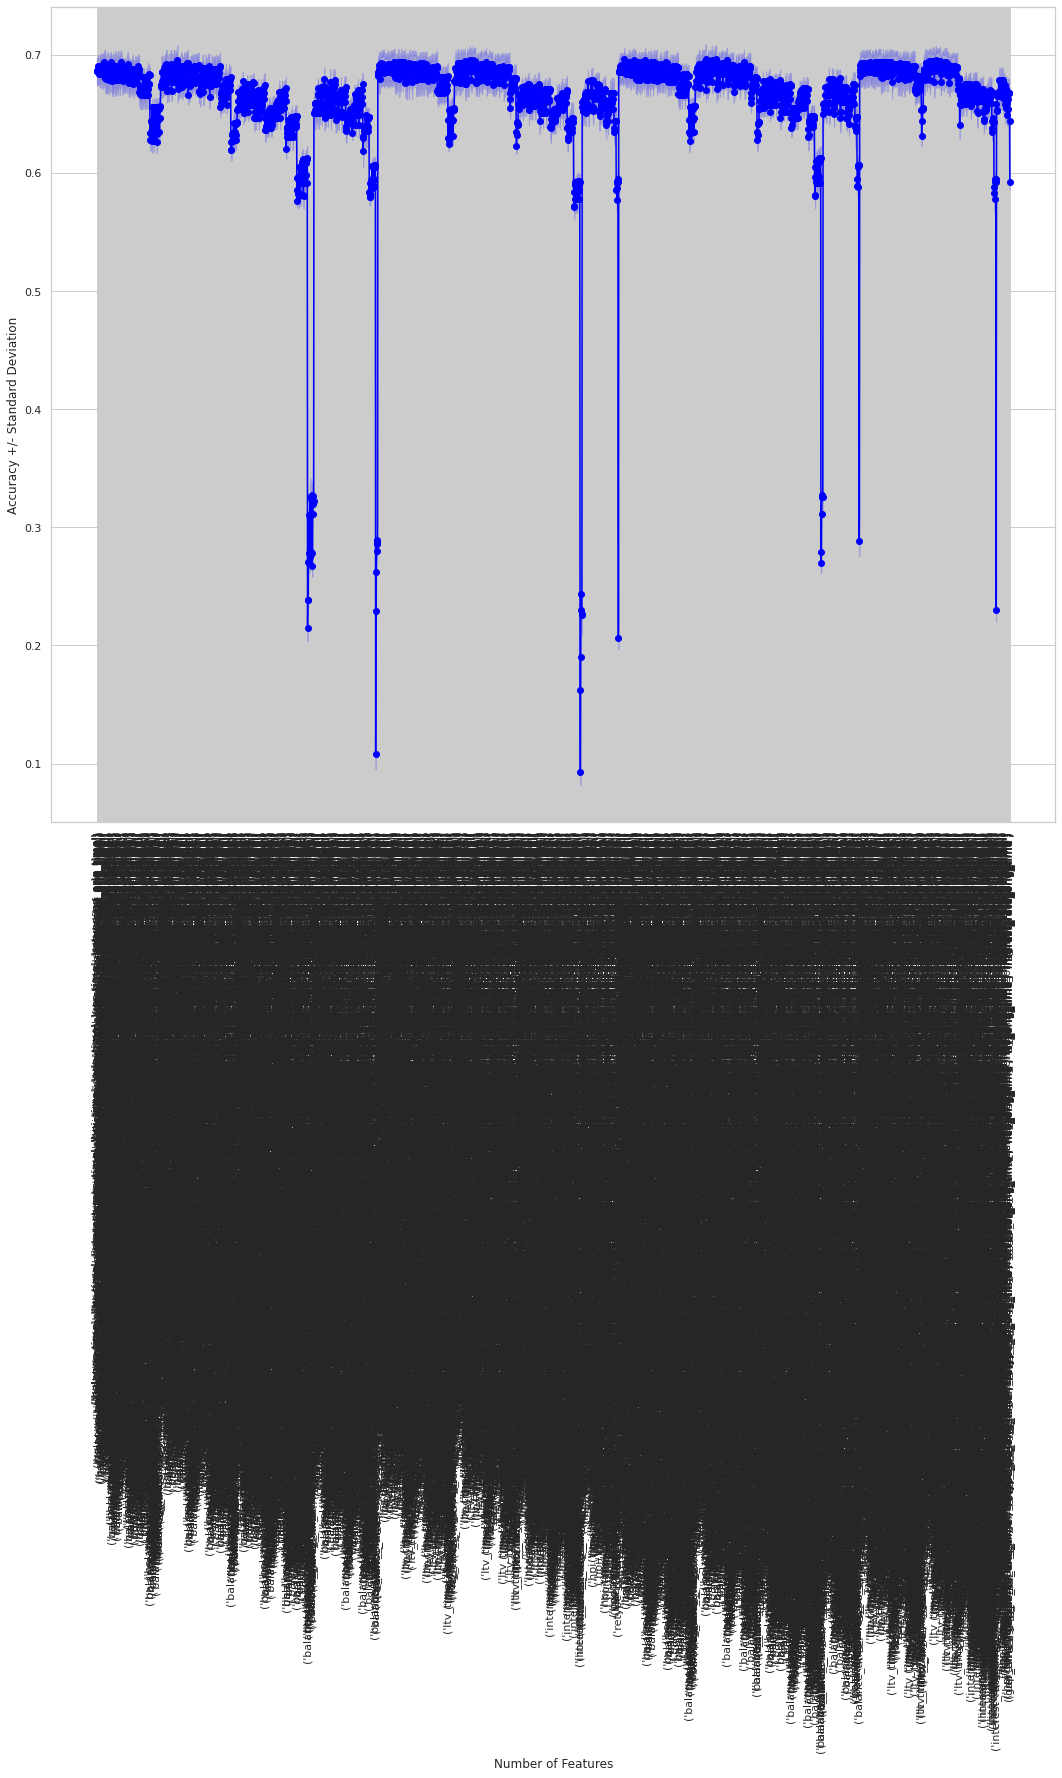

In [123]:
import matplotlib.pyplot as plt

# metric_dict = efs.get_metric_dict()

fig = plt.figure(1, figsize=(18, 15))
k_feat = sorted(metric_dict.keys())
avg = [metric_dict[k]['avg_score'] for k in k_feat]

upper, lower = [], []
for k in k_feat:
    upper.append(metric_dict[k]['avg_score'] +
                 metric_dict[k]['std_dev'])
    lower.append(metric_dict[k]['avg_score'] -
                 metric_dict[k]['std_dev'])

plt.fill_between(k_feat,
                 upper,
                 lower,
                 alpha=0.2,
                 color='blue',
                 lw=1)

plt.plot(k_feat, avg, color='blue', marker='o')
plt.ylabel('Accuracy +/- Standard Deviation')
plt.xlabel('Number of Features')
feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
plt.xticks(k_feat, 
           [str(metric_dict[k]['feature_names']) for k in k_feat], 
           rotation=90)
plt.show()

In [124]:
k_feat[0:6]

[0, 1, 2, 3, 4, 5]

In [125]:
avg[0:6]

[0.6862190103665571,
 0.6862190103665571,
 0.6867696642409019,
 0.685962844460786,
 0.6907837168839904,
 0.6881793703475151]

In [126]:
#### Plot features 

In [127]:
values = [0.6860433232794078, 0.704044630404463, 0.7005711177590427, 0.7040133779264213, 0.6991689750692521]

In [120]:
features = ['balance_time', 'ltv_time', 'interest_rate_time','hpi_time',
            'gdp_time', 'investor_orig_time', 'fico_orig_time', 'ltv_orig_time']

In [121]:
dictfea = dict(zip(features, values))

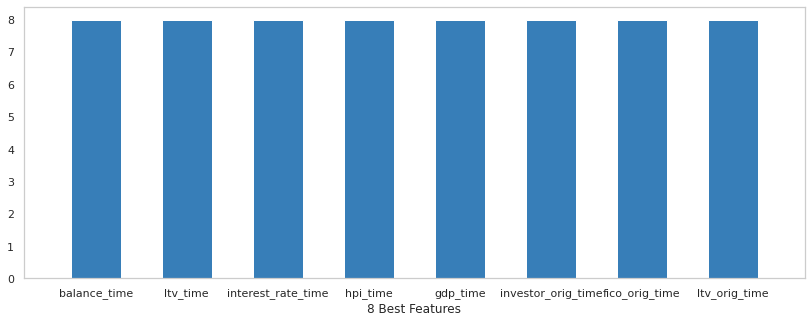

In [145]:

sns.set(style="whitegrid")
plt.figure(figsize=(14,5))

ax = plt.bar(features,height=8, color="#377eb8")


plt.grid(False)
plt.ylabel('')

plt.xlabel('8 Best Features',size=12)

    
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .55)


# Displaying the bar plot
plt.show()

###### Random Forest Importance

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [149]:
import time

start_time = time.time()

clf_rf = RandomForestClassifier(n_estimators=300, random_state=0)      
clr_rf = clf_rf.fit(X_train,y_train)
importances = clr_rf .feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("--- %s seconds ---" % (time.time() - start_time))

--- 15.402838706970215 seconds ---


In [150]:
X_train.columns

Index(['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time',
       'retype_sf_orig_time', 'investor_orig_time', 'fico_orig_time',
       'ltv_orig_time', 'interest_rate_orig_time'],
      dtype='object')

Feature ranking:
1. feature 1 (0.232820)
2. feature 10 (0.112898)
3. feature 3 (0.108754)
4. feature 0 (0.106663)
5. feature 2 (0.095787)
6. feature 4 (0.093613)
7. feature 5 (0.084800)
8. feature 12 (0.075628)
9. feature 11 (0.054240)
10. feature 8 (0.012636)
11. feature 9 (0.009177)
12. feature 7 (0.007433)
13. feature 6 (0.005551)


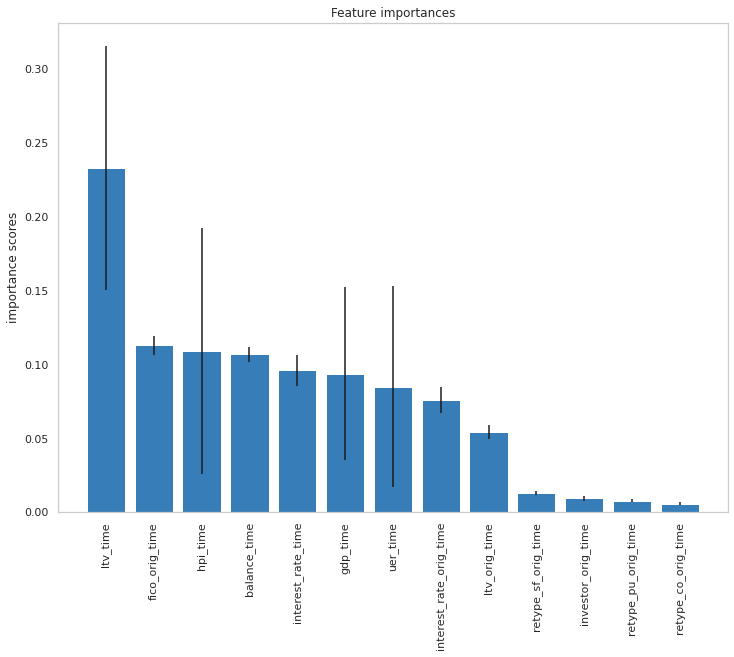

In [160]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(12, 9))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="#377eb8", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.grid(False)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel('importance scores')
plt.show()

In [158]:
print('Best subset top 8 feature names with RF:', X_train.columns[indices[0:8]])

Best subset top 8 feature names with RF: Index(['ltv_time', 'fico_orig_time', 'hpi_time', 'balance_time',
       'interest_rate_time', 'gdp_time', 'uer_time',
       'interest_rate_orig_time'],
      dtype='object')


##### Recursive feature elimination with cross validation

In [165]:
import time

start_time = time.time()

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
##### The "F1" scoring is proportional to the number of correct classifications
clf_gb = GradientBoostingClassifier(n_estimators=200)
rfecv = RFECV(estimator=clf_gb, step=1, cv=10,scoring='f1')   #5-fold cross-validation
rfecv = rfecv.fit(X_train,y_train)


print("--- %s seconds ---" % (time.time() - start_time))

--- 1106.5497806072235 seconds ---


In [166]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 10
Best features : Index(['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'investor_orig_time', 'fico_orig_time',
       'ltv_orig_time', 'interest_rate_orig_time'],
      dtype='object')


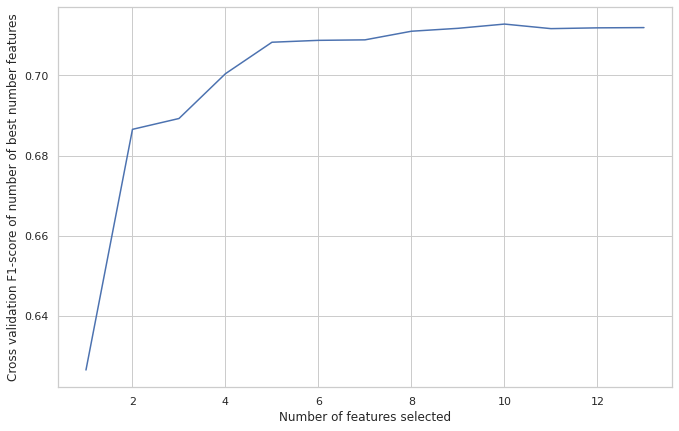

In [168]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure(figsize=(11,7))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score of number of best number features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
########### Select best combination based on results above and subset and save for modeling ###############

In [ ]:
# Final Selected Features Table
# Variable Name	Present in Feature Selector #1	Present in Feature Selector #2	Present in Feature Selector #3
# balance_time	Y	Y	Y
# ltv_time	Y	Y	Y
# interest_rate_time	Y	Y	Y
# hpi_time	Y	Y	Y
# gdp_time	Y	Y	Y
# fico_orig_time	N	Y	Y
# ltv_orig_time	Y	Y	N
# uer_time	Y	N	Y

In [ ]:
##### subset df and save to s3 for model with best 8 features

In [129]:
df.shape

(43685, 14)

In [131]:
df.columns

Index(['default', 'balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'uer_time', 'retype_co_orig_time', 'retype_pu_orig_time',
       'retype_sf_orig_time', 'investor_orig_time', 'fico_orig_time',
       'ltv_orig_time', 'interest_rate_orig_time'],
      dtype='object')

In [130]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 90,'display.max_columns',50):
              display(df.head(3))

,default,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,uer_time,retype_co_orig_time,retype_pu_orig_time,retype_sf_orig_time,investor_orig_time,fico_orig_time,ltv_orig_time,interest_rate_orig_time
0,1,29087.21,26.658065,9.200,146.45,2.715903,8.3,0,0,1,0,715,69.4,9.20
1,0,105654.77,65.469851,7.680,225.10,2.151365,4.7,0,0,1,0,558,80.0,7.68
2,0,44378.60,31.459735,11.375,217.37,1.692969,4.5,0,0,1,0,680,83.6,8.75


In [132]:
df[['default','balance_time','ltv_time','interest_rate_time',
'hpi_time',
'gdp_time',
'fico_orig_time',
'ltv_orig_time',
'uer_time']].shape

(43685, 9)

In [134]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 90,'display.max_columns',50):
              display(df[['default','balance_time','ltv_time','interest_rate_time','hpi_time','gdp_time','fico_orig_time',
                          'ltv_orig_time','uer_time']].head(3))

,default,balance_time,ltv_time,interest_rate_time,hpi_time,gdp_time,fico_orig_time,ltv_orig_time,uer_time
0,1,29087.21,26.658065,9.200,146.45,2.715903,715,69.4,8.3
1,0,105654.77,65.469851,7.680,225.10,2.151365,558,80.0,4.7
2,0,44378.60,31.459735,11.375,217.37,1.692969,680,83.6,4.5


In [135]:
df = df[['default','balance_time','ltv_time','interest_rate_time','hpi_time','gdp_time','fico_orig_time',
                          'ltv_orig_time','uer_time']]
df.reset_index(drop=True, inplace=True)

In [136]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 90,'display.max_columns',50):
              display(df.shape)

(43685, 9)

###### save to s3 path for modeling

In [138]:
import time
start_time = time.time()

wr.s3.to_csv(
    df=df,
    index=False,
    path="s3://daan888/projectcr/data/training/mortgage_risk_unique_training_data.csv")

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6617352962493896 seconds ---
